In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix

In [14]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [15]:
# Target encoding
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID
df = df.drop(columns=['customerID'])

# Fix TotalCharges
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
print("Dataset Shape:", df.shape)
print(df['Churn'].value_counts(normalize=True))


Dataset Shape: (7043, 20)
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


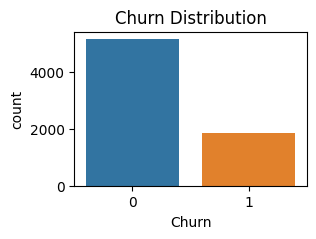

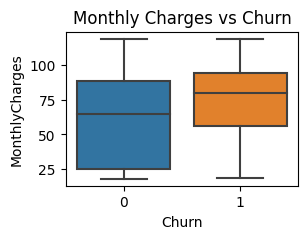

In [16]:
# EDA
plt.figure(figsize=(3,2))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

plt.figure(figsize=(3,2))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

In [17]:
# Preprocessing
X = df.drop(columns=['Churn'])
y = df['Churn']

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), cat_cols)
])

In [18]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [19]:
# Models

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:,1]

    acc = accuracy_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    results[name] = {"Accuracy": acc, "Recall": rec, "ROC-AUC": auc}

    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.66      0.56      0.60       374

    accuracy                           0.81      1409
   macro avg       0.75      0.73      0.74      1409
weighted avg       0.80      0.81      0.80      1409

Confusion Matrix:
 [[926 109]
 [165 209]]


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



=== Random Forest ===
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.47      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409

Confusion Matrix:
 [[918 117]
 [200 174]]

=== XGBoost ===
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1035
           1       0.59      0.50      0.54       374

    accuracy                           0.77      1409
   macro avg       0.71      0.69      0.69      1409
weighted avg       0.76      0.77      0.77      1409

Confusion Matrix:
 [[904 131]
 [188 186]]


`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Model Performance:
                      Accuracy    Recall   ROC-AUC
Logistic Regression  0.805536  0.558824  0.841840
Random Forest        0.775018  0.465241  0.818704
XGBoost              0.773598  0.497326  0.821687


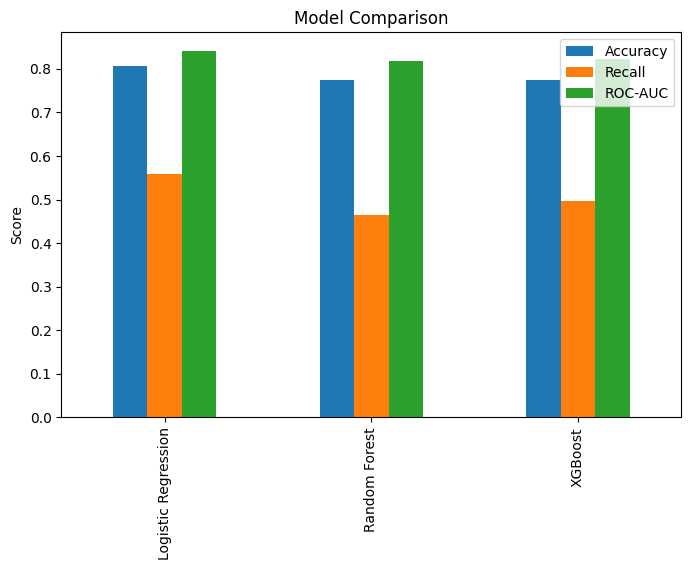

In [20]:
# Comparing Results
results_df = pd.DataFrame(results).T
print("\nModel Performance:\n", results_df)

results_df.plot(kind='bar', figsize=(8,5))
plt.title("Model Comparison")
plt.ylabel("Score")
plt.show()